In [1]:
#라이브러리 import
import os
from os.path import join

import numpy as np
import pandas as pd

import tensorflow as tf
import keras
from keras import layers, Input, models
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

2023-02-24 12:24:13.418177: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-24 12:24:13.488409: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-24 12:24:13.501917: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-24 12:24:13.758622: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvi

In [2]:
# head tail 다이사이즈 다름 확인
#df.tail()

In [3]:
#데이터 정보 확인
df=pd.read_pickle("/home/iai/Desktop/bsh/LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


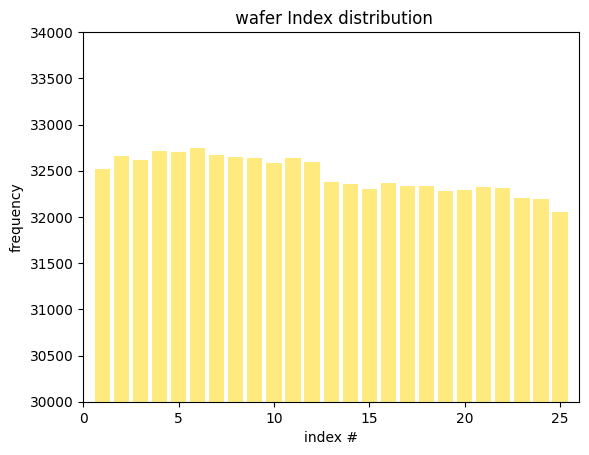

In [4]:
#데이터 분포확인 - 시각화 / feature engineering : 머신러닝 알고리즘이 작동할 수 있도록 하는 feature들을 만드는 과정
import matplotlib.pyplot as plt
%matplotlib inline

uni_Index=np.unique(df.waferIndex, return_counts=True)
plt.bar(uni_Index[0],uni_Index[1], color='gold', align='center', alpha=0.5)
plt.title(" wafer Index distribution")
plt.xlabel("index #")
plt.ylabel("frequency")
plt.xlim(0,26)
plt.ylim(30000,34000)
plt.show()

In [5]:
# 웨이퍼 인덱스 필요없음
df = df.drop(['waferIndex'], axis = 1)

# + 새로운 변수추가 / 웨이퍼 다이크기 다양함. : waferMapDim(가로,세로) 열생성 
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(10)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
120372,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,...",682.0,lot8073,[],[],"(31, 28)"
58595,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1801.0,lot4670,[],[],"(56, 41)"
447867,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",712.0,lot27488,[],[],"(32, 29)"
249363,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3014.0,lot15526,[[Training]],[[none]],"(64, 60)"
172710,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,...",533.0,lot11013,[],[],"(26, 26)"
674472,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",562.0,lot41988,[],[],"(29, 26)"
145408,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,...",712.0,lot9356,[],[],"(30, 31)"
632062,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1,...",515.0,lot39780,[],[],"(25, 27)"
202041,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,...",597.0,lot12882,[],[],"(23, 34)"
754905,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2,...",518.0,lot45242,[[Test]],[[none]],"(27, 25)"


In [6]:
#특정 해상도의 wafer map 가져오기 (26,26)
sub_df = df.loc[df['waferMapDim'] == (26, 26)]
sub_wafer = sub_df['waferMap'].values

sw = np.ones((1, 26, 26))
label = list()

for i in range(len(sub_df)):
    # skip null label
    if len(sub_df.iloc[i,:]['failureType']) == 0:
        continue
    sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, 26, 26)))
    label.append(sub_df.iloc[i,:]['failureType'][0][0])

x = sw[1:]
y = np.array(label).reshape((-1,1))

# check dimension
print('x shape : {}, y shape : {}'.format(x.shape, y.shape))

x shape : (14366, 26, 26), y shape : (14366, 1)


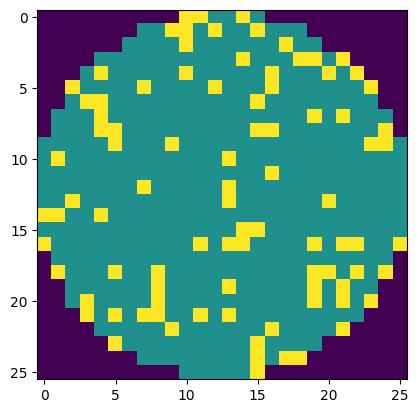

Faulty case : ['none'] 


In [7]:
# plot 1st data
plt.imshow(x[0])
plt.show()

# check faulty case
print('Faulty case : {} '.format(y[0]))

In [8]:
#채널 치수 확장  //  2D Convolution Autoencoder를 사용하기 위해
x = x.reshape((-1, 26, 26, 1))

In [9]:
faulty_case = np.unique(y)
print('Faulty case list : {}'.format(faulty_case))

for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']
Center : 90
Donut : 1
Edge-Loc : 296
Edge-Ring : 31
Loc : 297
Near-full : 16
Random : 74
Scratch : 72
none : 13489


In [10]:
# 정량적 변수들을 각 채널에 따라 원핫인코딩 / 원핫인코딩 : 표현하고 싶은 단어의 인덱스에 1의 값을 부여하고, 다른 인덱스에는 0을 부여하는 벡터 표현 방식
new_x = np.zeros((len(x), 26, 26, 3))

for w in range(len(x)):
    for i in range(26):
        for j in range(26):
            new_x[w, i, j, int(x[w, i, j])] = 1

#check new x dimension
new_x.shape

(14366, 26, 26, 3)

In [11]:
#클래스 불균형 문제 해결 -> 데이터 증강 -> convolutional autoencoder : 가중치 -> CNN
# 오토인코더 : 입력을 출력으로 복사하는 신경망  

# parameter
epoch=15
batch_size=512

input_shape = (26, 26, 3)
input_tensor = Input(input_shape) 
#인코드
encode  = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

latent_vector = layers.MaxPool2D()(encode)

# 디코드 : 복호화, 해석기
decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
decode_layer_2 = layers.UpSampling2D()
output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

# 디코드 레이어 연결
decode = decode_layer_1(latent_vector)
decode = decode_layer_2(decode)

ae = models.Model(input_tensor, output_tensor(decode))
ae.compile(optimizer='Adam', loss='mse')

ae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 26, 26, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 conv2d_transpose (Conv2DTra  (None, 13, 13, 64)       36928     
 nspose)                                                         
                                                                 
 up_sampling2d (UpSampling2D  (None, 26, 26, 64)       0         
 )                                                               
                                                             

2023-02-24 12:25:25.993185: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-24 12:25:25.996440: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-24 12:25:25.996522: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-24 12:25:25.996913: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow wit

In [12]:
ae.fit(new_x,new_x, batch_size=batch_size,epochs=epoch,verbose=1)

Epoch 1/15


2023-02-24 12:25:27.059360: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


29/29 [==============================] - 1s 7ms/step - loss: 0.1276
Epoch 2/15
29/29 [==============================] - 0s 6ms/step - loss: 0.0793
Epoch 3/15
29/29 [==============================] - 0s 6ms/step - loss: 0.0611
Epoch 4/15
29/29 [==============================] - 0s 6ms/step - loss: 0.0494
Epoch 5/15
29/29 [==============================] - 0s 6ms/step - loss: 0.0400
Epoch 6/15
29/29 [==============================] - 0s 6ms/step - loss: 0.0320
Epoch 7/15
29/29 [==============================] - 0s 6ms/step - loss: 0.0260
Epoch 8/15
29/29 [==============================] - 0s 6ms/step - loss: 0.0218
Epoch 9/15
29/29 [==============================] - 0s 6ms/step - loss: 0.0188
Epoch 10/15
29/29 [==============================] - 0s 6ms/step - loss: 0.0164
Epoch 11/15
29/29 [==============================] - 0s 6ms/step - loss: 0.0145
Epoch 12/15
29/29 [==============================] - 0s 6ms/step - loss: 0.0130
Epoch 13/15
29/29 [==============================] - 0s 6ms/

In [13]:
# 오토인코더 모델 층의 일부로 인코더 모델로 만든다 
encoder = models.Model(input_tensor, latent_vector)

#  오토인코더 모델 층의 일부로 디코더 모델을 만든다 
decoder_input = Input((13, 13, 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)

decoder = models.Model(decoder_input, output_tensor(decode))
# 기존의 결함이 있는 wafer를 인코딩
encoded_x = encoder.predict(new_x)
# 노이즈 첨가
noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64))

449/449 [==============================] - 0s 488us/step


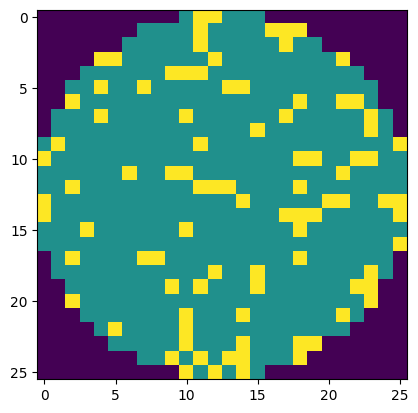

In [14]:
# 기존의 결함 있는 wafer data 시각화
plt.imshow(np.argmax(new_x[3], axis=2))

449/449 [==============================] - 0s 815us/step


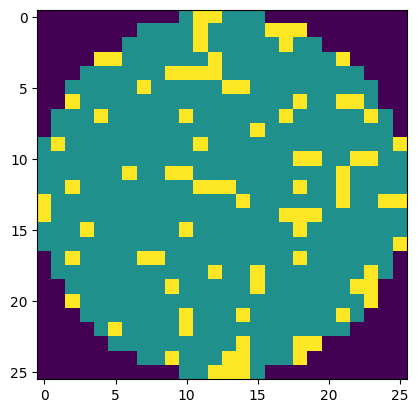

In [15]:
# 노이즈 첨가된 웨이퍼 데이터 시각화
noised_gen_x = np.argmax(decoder.predict(noised_encoded_x), axis=3)
plt.imshow(noised_gen_x[3])

In [16]:
#데이터 증강 +2000개
def gen_data(wafer, label):
   
    encoded_x = encoder.predict(wafer)
      
    gen_x = np.zeros((1, 26, 26, 3))
        
    for i in range((2000//len(wafer)) + 1):
        noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64)) 
        noised_gen_x = decoder.predict(noised_encoded_x)
        gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
    
    gen_y = np.full((len(gen_x), 1), label)       
    return gen_x[1:], gen_y[1:]

# 모든 faulty 데이터를 증강
for f in faulty_case : 
    # skip none case
    if f == 'none' : 
        continue
    
    gen_x, gen_y = gen_data(new_x[np.where(y==f)[0]], f)
    new_x = np.concatenate((new_x, gen_x), axis=0)
    y = np.concatenate((y, gen_y))

print('new_x shape 만든 후 : {}, new_y shape : {}'.format(new_x.shape, y.shape))

3/3 [==============================] - 0s 960us/step
new_x shape 만든 후 : (30707, 26, 26, 3), new_y shape : (30707, 1)


In [17]:
#늘어난 결함 종류별 데이터 확인
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 2160
Donut : 2002
Edge-Loc : 2368
Edge-Ring : 2046
Loc : 2376
Near-full : 2032
Random : 2146
Scratch : 2088
none : 13489


In [18]:
# 대체하지 않고 인덱스 선택
none_idx = np.where(y=='none')[0][np.random.choice(len(np.where(y=='none')[0]), size=83, replace=False)]

# 지정한 인덱스 데이터 제거
new_x = np.delete(new_x, none_idx, axis=0)
new_y = np.delete(y, none_idx, axis=0)

print('"none" class 제거 후 new_x shape : {}, new_y shape : {}'.format(new_x.shape, new_y.shape))

"none" class 제거 후 new_x shape : (30624, 26, 26, 3), new_y shape : (30624, 1)


In [19]:
for f in faulty_case :
    print('{} : {}'.format(f, len(new_y[new_y==f])))

Center : 2160
Donut : 2002
Edge-Loc : 2368
Edge-Ring : 2046
Loc : 2376
Near-full : 2032
Random : 2146
Scratch : 2088
none : 13406


In [20]:
for i, l in enumerate(faulty_case):
    new_y[new_y==l] = i
    
# 원-핫인코딩
new_y = to_categorical(new_y)

In [21]:
#  train, test 데이터 분리
x_train, x_test, y_train, y_test = train_test_split(new_x, new_y,
                                                    test_size=0.33,
                                                    random_state=2019)

print('Train x : {}, y : {}'.format(x_train.shape, y_train.shape)) #확인
print('Test x: {}, y : {}'.format(x_test.shape, y_test.shape))

Train x : (20518, 26, 26, 3), y : (20518, 9)
Test x: (10106, 26, 26, 3), y : (10106, 9)


In [22]:
# 2D CNN모델

def create_model():
    input_shape = (26, 26, 3)
    input_tensor = Input(input_shape)

    conv_1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_tensor)
    conv_2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv_1)
    conv_3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv_2)

    flat = layers.Flatten()(conv_3)

    dense_1 = layers.Dense(512, activation='relu')(flat)
    dense_2 = layers.Dense(128, activation='relu')(dense_1)
    output_tensor = layers.Dense(9, activation='softmax')(dense_2)

    model = models.Model(input_tensor, output_tensor)
    model.compile(optimizer='Adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

In [23]:
# 교차검증 모델 생성

# Make keras model to sklearn classifier.
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=1024, verbose=2) 
# 3-Fold Crossvalidation
kfold = KFold(n_splits=3, shuffle=True, random_state=2019) 
results = cross_val_score(model, x_train, y_train, cv=kfold)
# Check 3-fold model's mean accuracy
print('Simple CNN Cross validation score : {:.4f}'.format(np.mean(results)))

Epoch 1/10


/tmp/ipykernel_1386330/4095940200.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=1024, verbose=2)
2023-02-24 12:26:32.049684: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


14/14 - 2s - loss: 1.9594 - accuracy: 0.5145 - 2s/epoch - 151ms/step
Epoch 2/10
14/14 - 0s - loss: 0.7671 - accuracy: 0.7312 - 437ms/epoch - 31ms/step
Epoch 3/10
14/14 - 0s - loss: 0.4201 - accuracy: 0.8523 - 437ms/epoch - 31ms/step
Epoch 4/10
14/14 - 0s - loss: 0.2006 - accuracy: 0.9385 - 439ms/epoch - 31ms/step
Epoch 5/10
14/14 - 0s - loss: 0.0855 - accuracy: 0.9772 - 439ms/epoch - 31ms/step
Epoch 6/10
14/14 - 0s - loss: 0.0390 - accuracy: 0.9903 - 440ms/epoch - 31ms/step
Epoch 7/10
14/14 - 0s - loss: 0.0228 - accuracy: 0.9948 - 440ms/epoch - 31ms/step
Epoch 8/10
14/14 - 0s - loss: 0.0194 - accuracy: 0.9955 - 440ms/epoch - 31ms/step
Epoch 9/10
14/14 - 0s - loss: 0.0146 - accuracy: 0.9965 - 439ms/epoch - 31ms/step
Epoch 10/10
14/14 - 0s - loss: 0.0101 - accuracy: 0.9980 - 439ms/epoch - 31ms/step
7/7 - 0s - loss: 0.0330 - accuracy: 0.9904 - 359ms/epoch - 51ms/step
Epoch 1/10
14/14 - 1s - loss: 2.1472 - accuracy: 0.4740 - 1s/epoch - 73ms/step
Epoch 2/10
14/14 - 0s - loss: 0.7548 - accur

In [24]:
history = model.fit(x_train, y_train,validation_data=(x_test, y_test),epochs=epoch,batch_size=batch_size)

Epoch 1/15
41/41 - 2s - loss: 1.1107 - accuracy: 0.6763 - val_loss: 0.4237 - val_accuracy: 0.8808 - 2s/epoch - 45ms/step
Epoch 2/15
41/41 - 1s - loss: 0.1817 - accuracy: 0.9446 - val_loss: 0.0980 - val_accuracy: 0.9698 - 863ms/epoch - 21ms/step
Epoch 3/15
41/41 - 1s - loss: 0.0565 - accuracy: 0.9841 - val_loss: 0.0519 - val_accuracy: 0.9853 - 862ms/epoch - 21ms/step
Epoch 4/15
41/41 - 1s - loss: 0.0273 - accuracy: 0.9926 - val_loss: 0.1024 - val_accuracy: 0.9777 - 860ms/epoch - 21ms/step
Epoch 5/15
41/41 - 1s - loss: 0.0281 - accuracy: 0.9923 - val_loss: 0.0338 - val_accuracy: 0.9912 - 860ms/epoch - 21ms/step
Epoch 6/15
41/41 - 1s - loss: 0.0092 - accuracy: 0.9978 - val_loss: 0.0282 - val_accuracy: 0.9913 - 865ms/epoch - 21ms/step
Epoch 7/15
41/41 - 1s - loss: 0.0056 - accuracy: 0.9988 - val_loss: 0.0324 - val_accuracy: 0.9909 - 862ms/epoch - 21ms/step
Epoch 8/15
41/41 - 1s - loss: 0.0101 - accuracy: 0.9980 - val_loss: 0.0432 - val_accuracy: 0.9899 - 861ms/epoch - 21ms/step
Epoch 9/15


In [25]:
score = model.score(x_test, y_test)
print('Testing Accuracy:',score)

10/10 - 0s - loss: 0.1889 - accuracy: 0.9604 - 425ms/epoch - 42ms/step
Testing Accuracy: 0.9604195356369019


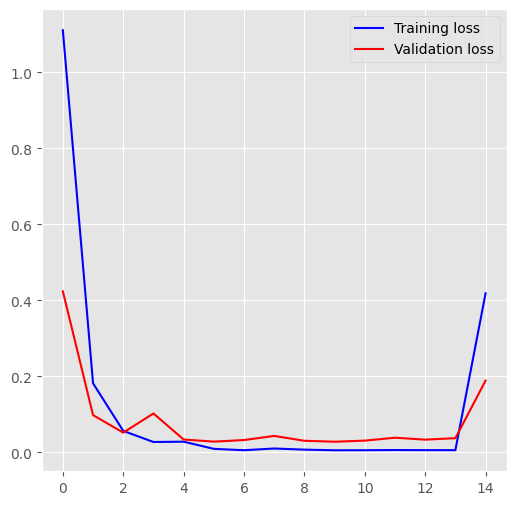

<Figure size 640x480 with 0 Axes>

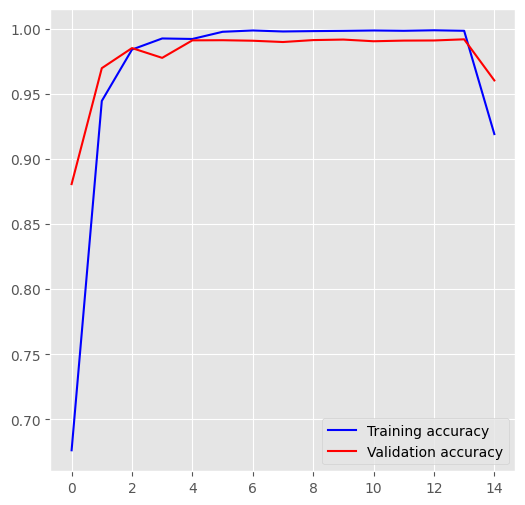

wafer defect 탐지 모델의 정확도: 96.00%


In [26]:
#시각화
def plot_model__hist(hist):
    plt.figure(figsize=(6,6))
    plt.style.use("ggplot")
    plt.plot(hist.history['loss'], color='b', label="Training loss")
    plt.plot(hist.history['val_loss'], color='r', label="Validation loss")
    plt.legend()
    plt.show()

    plt.figure()

    plt.figure(figsize=(6,6))
    plt.style.use("ggplot")
    plt.plot(hist.history['accuracy'], color='b', label="Training accuracy")
    plt.plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
    plt.legend(loc = "lower right")
    plt.show()

plot_model__hist(history)
print("wafer defect 탐지 모델의 정확도: {:5.2f}%".format(100*round(score,2)))